# Seminar 2. Training networks in PyTorch

On this seminar, we will train Lenet-5 on a MNIST dataset using PyTorch.

For the beginning, you can read several examples of training CNNs in PyTorch:
* [Example 1](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py)
* [Example 2](https://github.com/jcjohnson/pytorch-examples/blob/master/nn/two_layer_net_nn.py)

### Data loading in pytorch

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data

In [55]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

You will works with a MNIST dataset. It contains grayscale images of handwritten digits of size 28 x 28. The number of training objects is 60000. 


In pytorch, there is a special module to download MNIST. But for us it is more convinient to load the data ourselves.

In [3]:
from util import load_mnist

In [4]:
X_train, y_train, X_test, y_test = load_mnist()

The code below prepares short data (train and val) for seminar purposes (use this data to quickly learn model on CPU and to tune the hyperparameters). Also, we prepare the full data (train_full and test) to train a final model.

In [5]:
# shuffle data
np.random.seed(0)
idxs = np.random.permutation(np.arange(X_train.shape[0]))
X_train, y_train = X_train[idxs], y_train[idxs]
                            
X_train.shape

(60000, 1, 28, 28)

Pytorch offers convinient class DataLoader for mini batch generation. You should pass instance of Tensor Dataset to it.

In [6]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y).long())
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader_full = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)
# for validation purposes:
train_loader = get_loader(X_train[:15000], y_train[:15000])
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# check number of objects
val_loader.dataset.tensors[0].shape

torch.Size([15000, 1, 28, 28])

### Building LeNet-5

Convolutional layer (from Anton Osokin's presentation):
![slide](https://github.com/nadiinchi/dl_labs/raw/master/convolution.png)

You need to implement Lenet-5:

![Архитектура LeNet-5](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.png)

Construct a network according to the image and code examples given above. Use ReLU nonlinearity (after all linear and convolutional layers). The network must support multiplying the number of convolutions in each convolutional layer by k.

Please note that on the scheme the size of the image is 32 x 32 but in our code the size is 28 x 28.

Do not apply softmax at the end of the forward pass!

In [98]:
class CNN(nn.Module):
    def __init__(self, k=1):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6*k, 5), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(6*k, 16*k, 5), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )

        self.lin = nn.Sequential(
            nn.Linear(16*4*4*k, 120), 
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(), 
            nn.Linear(84, 10),
        )

    def forward(self, x):
        x = self.conv2(self.conv1(x))
        x = nn.Flatten()(x)

        return self.lin(x)
        

Let's count the number of the parameters in the network:

In [36]:
cnn = CNN()

In [37]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(cnn)

44426

### Training

Let's define the loss function:

In [18]:
criterion = nn.CrossEntropyLoss() # loss includes softmax

Also, define a device where to store the data and the model (cpu or gpu):

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cnn = cnn.to(device)

During training, we will control the quality on the training and validation set. This produces duplicates of the code. That's why we will define a function evaluate_loss_acc to evaluate our model on different data sets. In the same manner, we define function train_epoch to perform one training epoch on traiing data. Please note that we will compute the training loss _after_ each epoch (not averaging it during epoch).

In the propotypes, train and eval modes are noted. In our case, we don't need them (because we don't use neither dropout nor batch normalization). However, we will switch the regime so you can use this code in the future.

In [46]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    """
    for each batch 
    performs forward and backward pass and parameters update 
    
    Input:
    model: instance of model (example defined above)
    optimizer: instance of optimizer (defined above)
    train_loader: instance of DataLoader
    
    Returns:
    nothing
    
    Do not forget to set net to train mode!
    """
    model.train()

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    

def evaluate_loss_acc(loader, model, criterion, device):
    """
    Evaluates loss and accuracy on the whole dataset
    
    Input:
    loader:  instance of DataLoader
    model: instance of model (examle defined above)
    
    Returns:
    (loss, accuracy)
    
    Do not forget to set net to eval mode!
    """
    model.eval()
    k_correctly_predicted = 0
    k_total_samples = 0
    total_loss = 0

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()

            preds = output.argmax(-1)
            k_correctly_predicted += (preds == y_batch).sum().item()
            k_total_samples += y_batch.numel()

    accuracy = k_correctly_predicted / k_total_samples
    total_loss /= len(loader)

    return total_loss, accuracy
    
def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device, verbose=True):
    """
    Performs training of the model and prints progress
    
    Input:
    model: instance of model (example defined above)
    opt: instance of optimizer 
    train_loader: instance of DataLoader
    test_loader: instance of DataLoader (for evaluation)
    n_epochs: int
    
    Returns:
    4 lists: train_log, train_acc_log, val_log, val_acc_log
    with corresponding metrics per epoch
    """
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(train_loader, 
                                                  model, criterion, 
                                                  device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model, 
                                              criterion, device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))
            
    return train_log, train_acc_log, val_log, val_acc_log

Train the neural network, using defined functions. Use Adam as an optimizer, learning_rate=0.001, number of epochs = 20. For hold out, use val_loader, not test_loader.

In [20]:
N_EPOCHS = 20
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

train_log, train_acc_log, val_log, val_acc_log = train(cnn, 
                                                       optimizer, 
                                                       train_loader, 
                                                       val_loader, 
                                                       criterion, 
                                                       N_EPOCHS, 
                                                       device)

Epoch [1/20], Loss (train/test): 0.2802/0.2920, Acc (train/test): 0.9153/0.9112
Epoch [2/20], Loss (train/test): 0.1626/0.1791, Acc (train/test): 0.9491/0.9464
Epoch [3/20], Loss (train/test): 0.1104/0.1322, Acc (train/test): 0.9663/0.9597
Epoch [4/20], Loss (train/test): 0.0805/0.1065, Acc (train/test): 0.9760/0.9679
Epoch [5/20], Loss (train/test): 0.0677/0.0966, Acc (train/test): 0.9803/0.9703
Epoch [6/20], Loss (train/test): 0.0573/0.0903, Acc (train/test): 0.9829/0.9720
Epoch [7/20], Loss (train/test): 0.0521/0.0883, Acc (train/test): 0.9847/0.9732
Epoch [8/20], Loss (train/test): 0.0466/0.0863, Acc (train/test): 0.9857/0.9737
Epoch [9/20], Loss (train/test): 0.0419/0.0849, Acc (train/test): 0.9865/0.9745
Epoch [10/20], Loss (train/test): 0.0329/0.0812, Acc (train/test): 0.9893/0.9761
Epoch [11/20], Loss (train/test): 0.0272/0.0789, Acc (train/test): 0.9915/0.9773
Epoch [12/20], Loss (train/test): 0.0360/0.0941, Acc (train/test): 0.9873/0.9731
Epoch [13/20], Loss (train/test): 0.0

Let's visualize the activations of the network when images pass through it. The code below draws a table of images: the first column shows original images, the following 6 columns show images when the filters are applied to them. To use this code, save batch containing 10 images to x and the output of the first convolutional layer (before ReLU) on these images to y.

In [31]:
x_batch, _ = next(iter(train_loader))
x_batch = x_batch[:10].to(device)
y_batch = cnn.conv1[0].forward(x_batch)

In [32]:
def plot(x, y):
    plt.figure(figsize=(15, 15))
    for im in range(10):
        plt.subplot(11, 7, im*7+1)
        plt.imshow(x.data[im, 0])
        plt.axis("off")
        for i in range(6):
            plt.subplot(11, 7, im*7+i+2)
            plt.imshow(y.data[im, i].numpy())
            plt.axis("off")

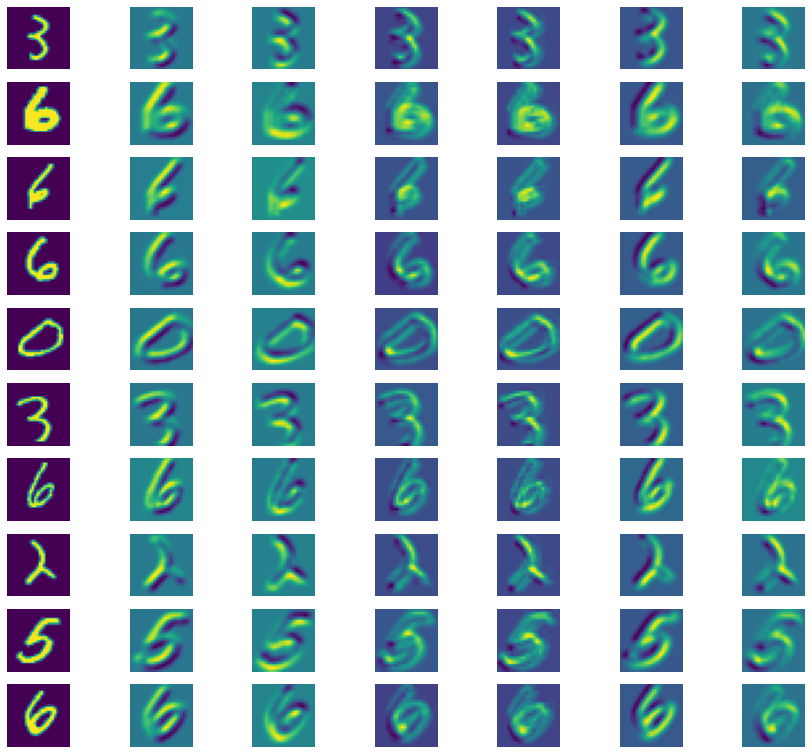

In [33]:
plot(x_batch.cpu(), y_batch.cpu())

Now visualize the result of applying the second convolutional layer (before ReLU) to images:

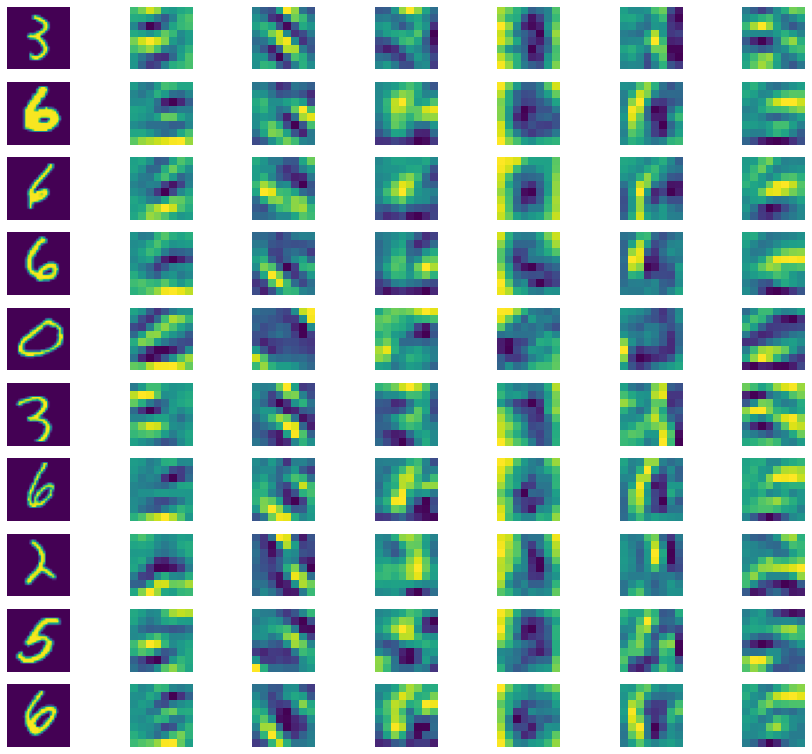

In [34]:
z_batch = cnn.conv2[0](cnn.conv1(x_batch))
plot(x_batch.cpu(), z_batch.cpu())


### Choosing  learning_rate and batch_size

Plot accuracy on the training and testing set v. s. training epoch for different learning parameters: learning rate$ \in \{0.0001, 0.001, 0.01\}$, batch size $\in \{64, 256\}$. 

The best option is to plot training curves on the left graph and validation curves on the right graph with the shared y axis (use plt.ylim).

How do learning rate and batch size affect the final quality of the model?

In [47]:
losses = []
qualities = []

for i, lr in enumerate((0.0001, 0.001, 0.01)):
    for j, batch_size in enumerate((64, 128, 256)):
        train_loader = get_loader(X_train[:15000], 
                                  y_train[:15000], 
                                  batch_size)
        val_loader = get_loader(X_train[15000:30000], 
                                y_train[15000:30000], 
                                batch_size)
        
        model = CNN().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_log, train_acc_log, val_log, val_acc_log = train(model, 
                                                              optimizer, 
                                                              train_loader, 
                                                              val_loader, 
                                                              criterion, 
                                                              N_EPOCHS, 
                                                              device, 
                                                              False)
        losses.append((train_log, val_log))
        qualities.append((train_acc_log, val_acc_log))

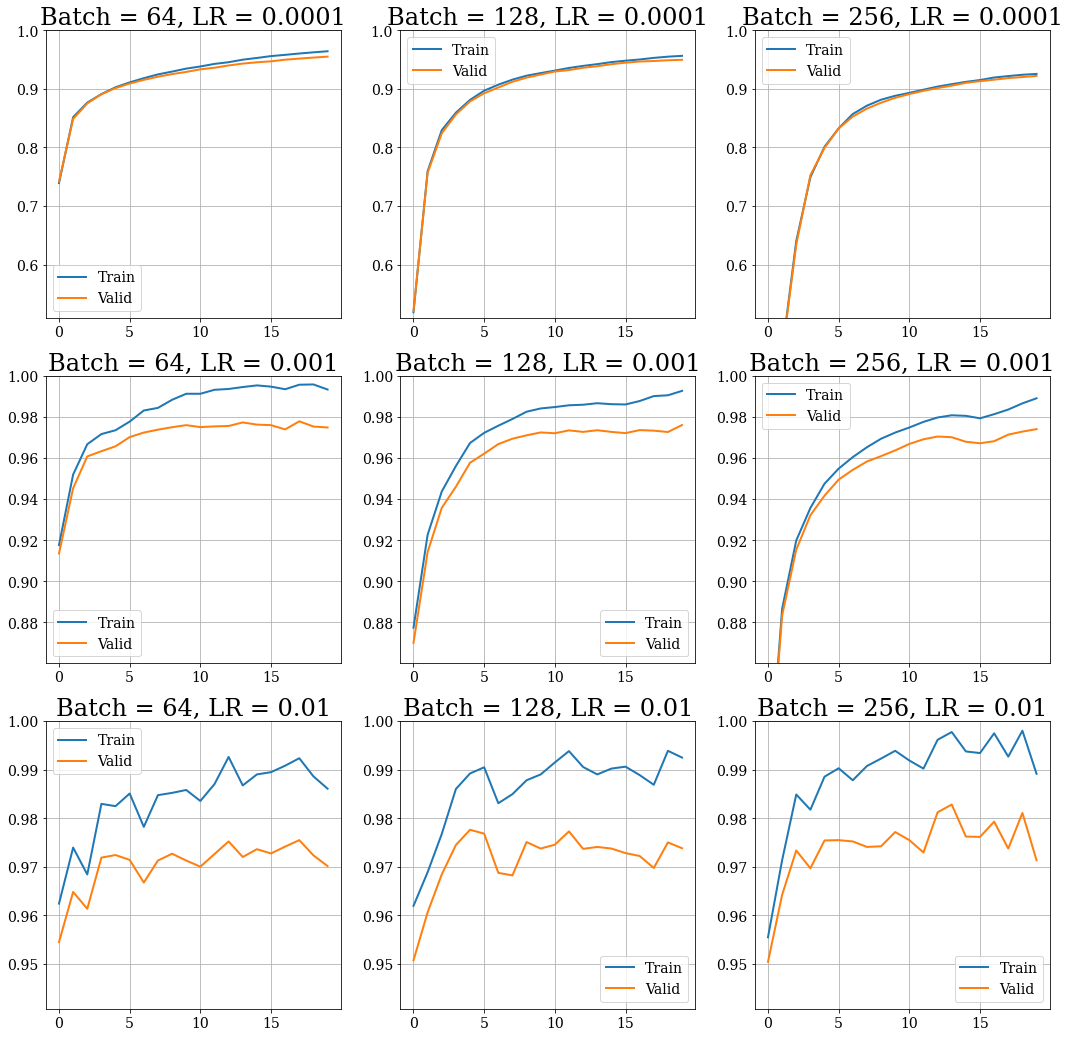

In [87]:
LRs = (0.0001, 0.001, 0.01)
BATCH_SIZES = (64, 128, 256)
EPS = 0.01 # for plt.ylim

fig, axes = plt.subplots(nrows=3, ncols=3, 
                         figsize=(18, 18))

for i, lr in enumerate(LRs):
    min_val = np.array(qualities[3*i:3*i+2]).min()

    for j, batch_size in enumerate(BATCH_SIZES):
        axes[i, j].set_title(f'Batch = {batch_size}, LR = {lr}', loc='center')

        axes[i, j].plot(qualities[3*i+j][0],
                        label='Train')
        axes[i, j].plot(qualities[3*i+j][1],
                        label='Valid')
        axes[i, j].set_ylim(min_val - EPS, 1)
        axes[i, j].grid(True)
        axes[i, j].legend()

**Ответ:** При lr = 0.01 и batch_size $\in$ {128, 256} скорость обучения высока: уже на пятой эпохе точность предсказания на обучающей выборке составляет 0.99, в то время как остальные модели достигают того же качества не раньше, чем на 10 эпохе.  
При lr = 0.0001 лаг между качеством на обучающей и тестовой выборках минимален.

### Changing the architecture

Try to modify our architecture: increase the number of filters and to reduce the number of fully-connected layers.

Insert numbers in the brackets:
* LeNet-5 classic (6 and 16 convolutions):  training acc: 0.9977,  validation acc: 0.9892
* Number of convolutions x 4 (24 и 64 convolutions):  training acc: 0.9994  validation acc: 0.9933
* Removing fully connected layer: the previous network with 1 FC layer: training acc: 0.9921, validation acc: 0.9859
    
    

In [96]:
BATCH_SIZE = 64
LR = 0.001
train_loader = get_loader(X_train, 
                          y_train, 
                          BATCH_SIZE)
test_loader = get_loader(X_test, 
                        y_test, 
                        BATCH_SIZE)

**1. LeNet-5 (6-16) на всем датасете**

In [106]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_log, train_acc_log, val_log, val_acc_log = train(model, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      criterion, 
                                                      N_EPOCHS, 
                                                      device, 
                                                      False)

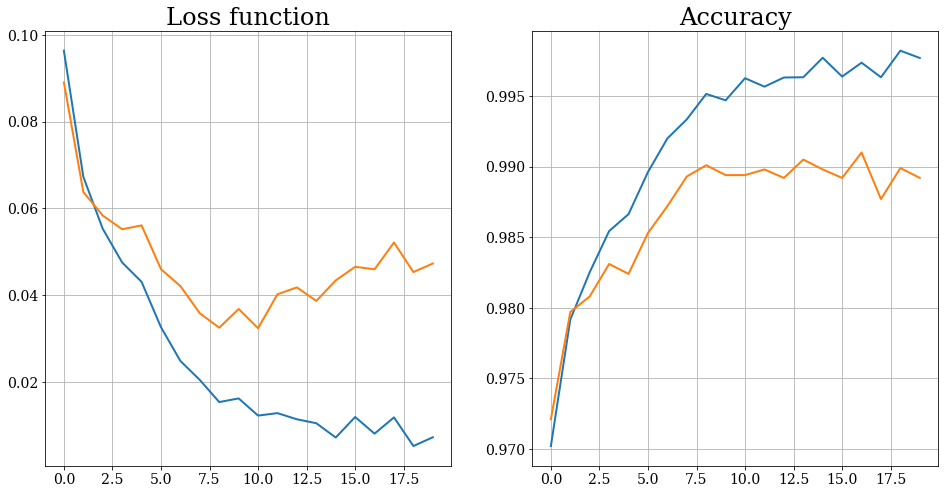

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(train_log, label="Train")
axes[0].plot(val_log, label="Test")
axes[0].set_title("Loss function")
axes[0].grid(True)

axes[1].plot(train_acc_log, label="Train")
axes[1].plot(val_acc_log, label="Test")
axes[1].set_title("Accuracy")
axes[1].grid(True)

plt.show()

**2. LeNet-5 (24-64) на всем датасете**

In [99]:
model = CNN(4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_log, train_acc_log, val_log, val_acc_log = train(model, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      criterion, 
                                                      N_EPOCHS, 
                                                      device, 
                                                      False)

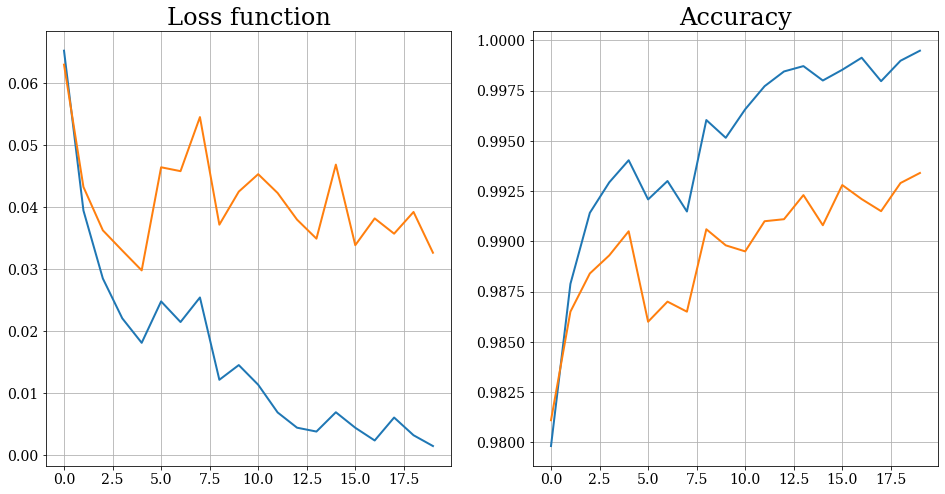

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(train_log, label="Train")
axes[0].plot(val_log, label="Test")
axes[0].set_title("Loss function")
axes[0].grid(True)

axes[1].plot(train_acc_log, label="Train")
axes[1].plot(val_acc_log, label="Test")
axes[1].set_title("Accuracy")
axes[1].grid(True)

plt.show()

**3. LeNet-5 с одним FC слоем**

In [102]:
model = CNN().to(device)
model.lin = nn.Linear(256, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_log, train_acc_log, val_log, val_acc_log = train(model, 
                                                      optimizer, 
                                                      train_loader, 
                                                      test_loader, 
                                                      criterion, 
                                                      N_EPOCHS, 
                                                      device, 
                                                      False)

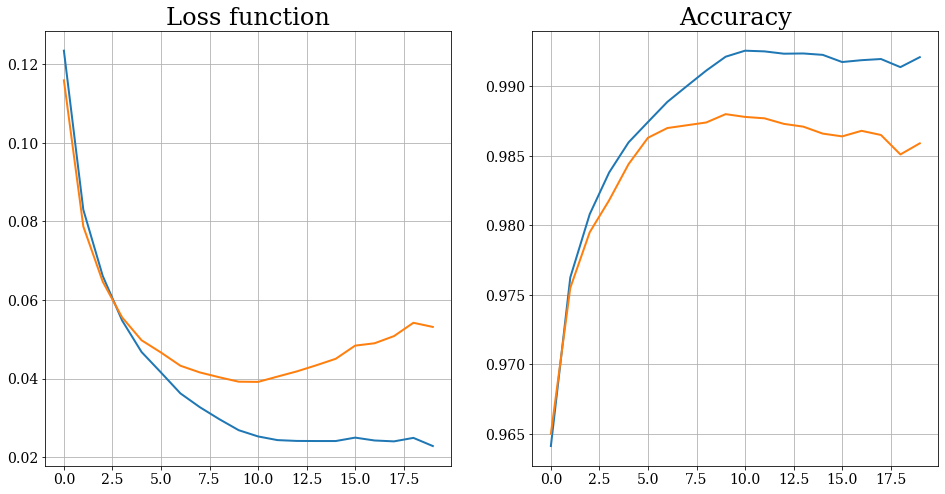

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(train_log, label="Train")
axes[0].plot(val_log, label="Test")
axes[0].set_title("Loss function")
axes[0].grid(True)

axes[1].plot(train_acc_log, label="Train")
axes[1].plot(val_acc_log, label="Test")
axes[1].set_title("Accuracy")
axes[1].grid(True)

plt.show()

Choose the learning rate, batch size and the architecture based on your experiments. Train a network on the full dataset and print accuracy on the full test set.